* Transformers is all you need

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


## Importing dependencies

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
# sns.set_style("whitegrid")
# sns.despine()
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Loading Data and splitting it to train and test

In [4]:
from datasets import load_dataset

bbc_news = load_dataset("gopalkalpande/bbc-news-summary")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/gopalkalpande--bbc-news-summary-2a01b492fd0ba579/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
bbc_news = bbc_news['train'].train_test_split(test_size=0.2,shuffle=True)
bbc_news

DatasetDict({
    train: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 1779
    })
    test: Dataset({
        features: ['File_path', 'Articles', 'Summaries'],
        num_rows: 445
    })
})

## visualizing data

In [6]:
bbc_news['train'][0]

{'File_path': 'tech',
 'Articles': 'Apple sues to stop product leaks..Computer firm Apple has issued a lawsuit to prevent online leaks of information about future products...The lawsuit, against an unidentified individual, comes just weeks before the MacWorld conference in San Francisco, used to showcase new products. The complaint said an "unidentified individual... has recently misappropriated and disseminated confidential information". The lawsuit was filed with the Santa Clara California Superior Court. Apple is famously secretive about its future product launches while Apple users are equally famous for speculating about new technology from the company. Fans have speculated in recent weeks about the possibility of a new type of iPod being announced at the MacWorld conference...Apple said in the seven-page complaint, filed on 13 December, that it did not know the "true names or capacities, whether individual, associate, corporate or otherwise," of the defendants. The company said i

<Axes: ylabel='count'>

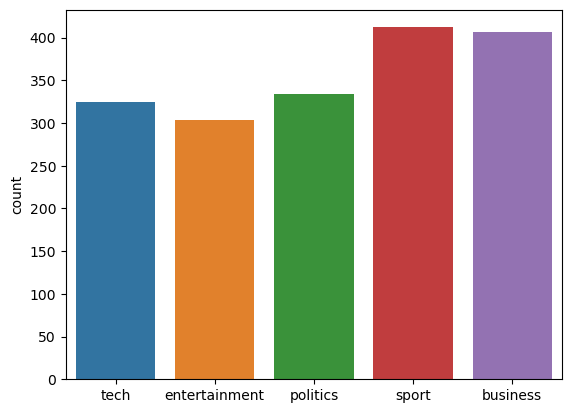

In [7]:
category_train = bbc_news['train']['File_path']
sns.countplot(x=category_train)

<Axes: ylabel='count'>

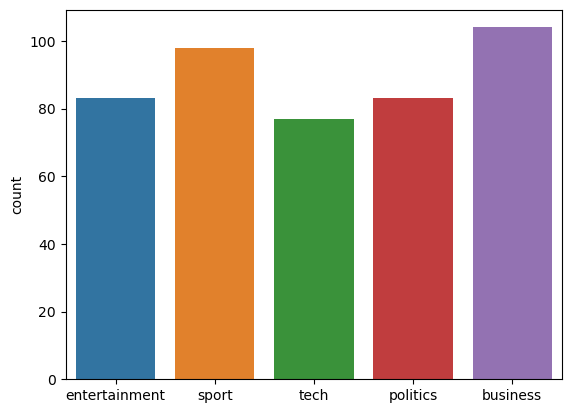

In [8]:
category_test = bbc_news['test']['File_path']
sns.countplot(x=category_test)

In [9]:
bbc_news.set_format(type='pandas')
df_train = bbc_news['train'][:]
df_test = bbc_news['test'][:]

## Preprocessing dataset

In [10]:
import re
import nltk
nltk.download('punkt')
!pip install contractions
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.tokenize import sent_tokenize
from datasets import Dataset,DatasetDict
def remove_stopwords(text):
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    processed_text = [word for word in words if word not in stopwords.words('english')]
#     print(processed_text)
    processed_text = [ lemmatizer.lemmatize(word) for word in processed_text]
#     print(processed_text)
    return ' '.join(processed_text)
def pre_process_df(df1):
    df = df1.copy()
    for col in ['Articles']:
        df[col] = df[col].apply(lambda x: contractions.fix(x))
        df[col] = df[col].apply(str.lower)
        df[col] = df[col].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))
        df[col] = df[col].apply(lambda x: remove_stopwords(x))
        df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
    return df
bbc_news_train = pre_process_df(df_train)
bbc_news_test = pre_process_df(df_test)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.8 MB/s eta 0:00:00
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  


In [11]:
def add_text(df1):
    df = df1.copy()
    list_text = []
    for article,summary in zip(df['Articles'],df['Summaries']):
        new_text = article + " TL;DR " + summary
        list_text.append(new_text)
    df['new_text'] = list_text
    return df 
bbc_news_train = add_text(bbc_news_train)
bbc_news_test = add_text(bbc_news_test)

In [13]:
print(bbc_news_train['Articles'][0])

apple sue stop product leak computer firm apple issued lawsuit prevent online leak information future product lawsuit unidentified individual come week macworld conference san francisco used showcase new product complaint said unidentified individual recently misappropriated disseminated confidential information lawsuit filed santa clara california superior court apple famously secretive future product launch apple user equally famous speculating new technology company fan speculated recent week possibility new type ipod announced macworld conference apple said seven page complaint filed 13 december know true name capacity whether individual associate corporate otherwise defendant company said would amend complaint discovered name allegedly leaked information first time apple sued people posted information future product internet december 2002 apple sued former contractor allegedly posted online drawing image engineering detail company powermac g4 computer statement apple said current 

In [14]:
print(bbc_news_train['Summaries'][0])

In a statement, Apple said of the current lawsuit: "Apple has filed a civil complaint against unnamed individuals who we believe stole our trade secrets and posted detailed information about an unannounced Apple product on the internet."Computer firm Apple has issued a lawsuit to prevent online leaks of information about future products.It is not the first time Apple has sued people who have posted information about future products on the internet.The complaint said an "unidentified individual... has recently misappropriated and disseminated confidential information".Apple said in the seven-page complaint, filed on 13 December, that it did not know the "true names or capacities, whether individual, associate, corporate or otherwise," of the defendants.


In [15]:
print(bbc_news_train['new_text'][0])

apple sue stop product leak computer firm apple issued lawsuit prevent online leak information future product lawsuit unidentified individual come week macworld conference san francisco used showcase new product complaint said unidentified individual recently misappropriated disseminated confidential information lawsuit filed santa clara california superior court apple famously secretive future product launch apple user equally famous speculating new technology company fan speculated recent week possibility new type ipod announced macworld conference apple said seven page complaint filed 13 december know true name capacity whether individual associate corporate otherwise defendant company said would amend complaint discovered name allegedly leaked information first time apple sued people posted information future product internet december 2002 apple sued former contractor allegedly posted online drawing image engineering detail company powermac g4 computer statement apple said current 

In [16]:
ds_dict = {'train' : Dataset.from_pandas(bbc_news_train),
           'test' : Dataset.from_pandas(bbc_news_test)}
bbc_news = DatasetDict(ds_dict)

In [17]:
bbc_news['train'][10]

{'File_path': 'politics',
 'Articles': 'kinnock urge reform lord neil kinnock said acceptance seat house lord allow help achieve progress substantial democratic reform bbc breakfast frost put mr kinnock referred lord member brigand mugger briber gangster outgoing european commissioner said comment made 26 year ago needed put context said advocate reform needed inside lord vote pointed additional democratic reform going take place going require advocate lord people willing vote mr kinnock added second factor behind acceptance peerage appointment chairman british council history demonstrates immensely useful british council chairman house lord conclusive factor mr kinnock said thought decision quite long time long reservation lord added process reform developed substantially sufficiently consequently take factor consideration decision made glibly former labour leader said would probably take title lord kinnock bedwellty first constituency selected 1969',
 'Summaries': 'He said advocates 

## Converting dataset to format required by our model

In [32]:
from transformers import AutoTokenizer
model_checkpoint = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
context_length = 128

def tokenize(element):
    outputs = tokenizer(
        element["new_text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = bbc_news.map(
    tokenize, batched=True, remove_columns=bbc_news["train"].column_names
)
tokenized_datasets

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 5964
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 1497
    })
})

## Importing pretrained model

In [33]:
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained(model_checkpoint)

## Args for finetuning model for our bbc dataset

In [41]:
from transformers import TrainingArguments

batch_size = 2
num_train_epochs = 4
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-bbc-lemmatized",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
#     push_to_hub = True
)

In [43]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer,mlm = False)

## Finetuning our model

In [44]:
from transformers import Trainer

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [45]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.887400,4.269771
2,3.244700,4.310873
3,2.760400,4.442122
4,2.440400,4.590424


TrainOutput(global_step=11928, training_loss=3.083210444306464, metrics={'train_runtime': 2833.8602, 'train_samples_per_second': 8.418, 'train_steps_per_second': 4.209, 'total_flos': 5538770942164992.0, 'train_loss': 3.083210444306464, 'epoch': 4.0})

In [47]:
trainer.evaluate()

{'eval_loss': 4.590423583984375,
 'eval_runtime': 32.2219,
 'eval_samples_per_second': 46.459,
 'eval_steps_per_second': 23.245,
 'epoch': 4.0}

## Using saved checkpoint to see how our model works!!!

In [50]:
from transformers import pipeline

hub_model_id = "/kaggle/working/gpt2-medium-finetuned-bbc-lemmatized/checkpoint-11500"
summarizer = pipeline("text-generation", model=hub_model_id)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [51]:
bbc_news["test"][0]["Articles"]

'u box office set record high ticket sale u box office predicted break record year figure expected reach 9 4 billion beating 2002 time high overall figure could dampened lack christmas hit like last year oscar winning lord ring traditionally ticket sale festive season account 20 annual total although admission actually fallen year predicted high increasing ticket price according exhibitor relation president paul dergarabedian average cost cinema ticket could high 6 25 2004 compared 5 80 2002 year biggest hit passion christ fahrenheit 9 11 came outside major studio usually responsible key blockbuster many film well audience necessarily film made lot money said mr dergarabedian added surprise hit come art house offering napoleon dynamite critical hit sideways sony picture responsible hit like spiderman 2 grudge expected top domestic market share second time three year 1 billion plus sale third consecutive year sony picture entertainment vice chairman jeff blake said really diverse slate 

In [66]:
def print_summary(idx):
    review = bbc_news["test"][idx]["Articles"]
#     print(idx)
#     title = bbc_news["test"][idx]["File_Path"]
    summary = summarizer(bbc_news["test"][idx]["new_text"])[0]["generated_text"]
    print(f"'>>> Review: {review}'")
# #     print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")
    final = summary.replace(review + ' TL;DR ', ' ')
    print(f"\n'>>> Final: {final}'")

In [67]:
print_summary(100)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 400, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


'>>> Review: borussia dortmund near bust german football club former european champion borussia dortmund warned go bankrupt rescue talk creditor fail company share tumbled said entered life threatening profitability financial situation borussia dortmund posted record loss missed rent payment westfallen stadium chief executive gerd niebaum stepped last week creditor pushing greater control share borussia dortmund germany stock market listed football club dropped almost 23 2 05 euro early afternoon trading fund manager florian hamm borussia dortmund largest investor said would invest money company got greater say run demand better transparency quoted saying germany manger magazin club also faced call appoint executive outside club borussia dortmund posted record loss 68m euro 89m £47m 12 month june made loss 27 2m euro first half current fiscal year said total debt increase 134 7m euro middle 2006 unless restructuring plan pushed bill mismanagement past year said hvb analyst peter thilo 